# 第6章: 機械学習

本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

## 50. データの入手・整形

News Aggregator Data Setをダウンロードし，以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [2]:
### 1 ###
"""
path = 'readme.txt'
with open(path) as f:
  s = f.read()
  print(s)
### """

"\npath = 'readme.txt'\nwith open(path) as f:\n  s = f.read()\n  print(s)\n### "

In [3]:
### 2 ###
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

columns_name = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df = pd.read_csv('newsCorpora.csv', header=None, sep='\t', names=columns_name)
### 3 ###
df = df.query(' PUBLISHER in ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"] ').sample(frac=1).reset_index(drop=True)
### 4 ###
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=144, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=144, stratify=valid_test['CATEGORY'])

train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

print(f'{"="*5}train{"="*5}\n {train["CATEGORY"].value_counts()}\n')
print(f'{"="*5}valid{"="*5}\n {valid["CATEGORY"].value_counts()}\n')
print(f'{"="*5}test{"="*5}\n {test["CATEGORY"].value_counts()}\n')

=====train=====
 b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64

=====valid=====
 b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64

=====test=====
 b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64



## 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれ`train.feature.txt`，`valid.feature.txt`，`test.feature.txt`というファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [4]:
df.head(10)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,276659,Fitch Downgrades Remy Cointreau SA to 'BB+'; O...,http://www.reuters.com/article/2014/06/10/fitc...,Reuters,b,dAZC0aRMk1ONyvMUjTyEB_iZmrZLM,www.reuters.com,1402654004566
1,273212,Dai-Ichi Life to buy Protective Life for $5.7 ...,http://in.reuters.com/article/2014/06/04/daiic...,Reuters,b,dCUjk7iNj5qQo4MvVktiMHmgm_T2M,in.reuters.com,1401889927814
2,399684,Driverless cars on British roads within a year...,http://www.dailymail.co.uk/sciencetech/article...,Daily Mail,t,dP5gkImN5YNcYlMacFv6I-Jdff81M,www.dailymail.co.uk,1406725348495
3,195431,Jennifer Lopez is blown away by Jena Irene's E...,http://www.dailymail.co.uk/tvshowbiz/article-2...,Daily Mail,e,dEvGnOAMPzBt6XMkIH9LpiULfLYSM,www.dailymail.co.uk,1399575952257
4,62575,Gwyneth Paltrow And Chris Martin's Split Anger...,http://www.contactmusic.com/article/gwyneth-pa...,Contactmusic.com,e,dD0tPP0taGNUTeM9SQMvlckAOCu3M,www.contactmusic.com,1396076743552
5,144265,Captain America beats up the competition at th...,http://www.dailymail.co.uk/tvshowbiz/article-2...,Daily Mail,e,doEnu8fR7PjyEfMFiIjTAlE34XjLM,www.dailymail.co.uk,1398060938704
6,367866,Deny the Merger: The Collusion of Verizon-Wire...,http://www.huffingtonpost.com/bruce-kushnick/d...,Huffington Post,t,dm0bAkZBAiPpD7Mwwc_PQd1BtH9HM,www.huffingtonpost.com,1404825424633
7,400844,Boeing to Build Largest 787 Dreamliner in Sout...,http://www.businessweek.com/news/2014-07-30/bo...,Businessweek,b,dWwpEduMQQLu8VMJHP-1jL0h6xvfM,www.businessweek.com,1406773343237
8,289577,Kris Jenner - Kris Jenner wants circus wedding...,http://www.contactmusic.com/story/kris-jenner-...,Contactmusic.com,e,doavUp3LtOyQ8RMWJQlb_fhTA3GlM,www.contactmusic.com,1402869587772
9,373757,Ellen Degeneres - Ellen Degeneres Makes $15 Mi...,http://www.contactmusic.com/story/ellen-degene...,Contactmusic.com,e,diBHl3E_FLE0OxMplZvzbEezdS10M,www.contactmusic.com,1404917855099


In [5]:
train_mid = train.copy()
valid_mid = valid.copy()
test_mid = test.copy()

train_mid['split_type'] = 'train'
valid_mid['split_type'] = 'valid'
test_mid['split_type'] = 'test'

all_data = pd.concat([train_mid, valid_mid, test_mid]).reset_index(drop=True)
all_data.head(10)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,split_type
0,397611,Sierra Leone Is New Epicenter of Ebola Outbrea...,http://www.businessweek.com/news/2014-07-29/si...,Businessweek,m,dPRAtkMW90_wGQMNUTOqHxTcZ72oM,www.businessweek.com,1406670184284,train
1,364617,Corn Avalanche Coming as Rain Trumps US Planti...,http://www.businessweek.com/news/2014-07-06/co...,Businessweek,b,d0CNcutiQwOuUYMH4j1yxlDjwJ8gM,www.businessweek.com,1404755754494,train
2,55444,Autism Rate Has Increased -- 1 In 68 Kids Now ...,http://www.huffingtonpost.com/2014/03/27/autis...,Huffington Post,m,dn3vkwT6-TdkIXMiRXPpYCyb8-pTM,www.huffingtonpost.com,1395967639410,train
3,372069,FOREX-Kiwi firm near 3-year high; greenback aw...,http://in.reuters.com/article/2014/07/09/marke...,Reuters,b,dyutEFDUhlu4tsMnZwi-wssrzIb-M,in.reuters.com,1404903597294,train
4,321229,Thousands of North Koreans attended huge Pyong...,http://www.dailymail.co.uk/news/article-267039...,Daily Mail,e,dGrAtU0IrYK0V5MBepXMiSz86OFSM,www.dailymail.co.uk,1403804903090,train
5,185883,Republicans Portray Obama Climate Push As A Di...,http://www.huffingtonpost.com/2014/05/06/repub...,Huffington Post,t,dTCdVumx5cP8FmMQW1EE_uDjklwNM,www.huffingtonpost.com,1399443091353,train
6,141206,"UPDATE 1-Toyota to launch China-made Corolla, ...",http://in.reuters.com/article/2014/04/20/autos...,Reuters,b,dvCPexIFW0jYxBM_2UStT7xM7zgHM,in.reuters.com,1397998702081,train
7,402400,UPDATE 2-Hyundai recalls 883000 Sonata sedans ...,http://in.reuters.com/article/2014/07/30/hyund...,Reuters,t,dFfHbuzWA3vUlvMV5bNBUtpOkfrPM,in.reuters.com,1406788509625,train
8,89894,Peaches Geldof - Peaches Geldof was devoted to...,http://www.contactmusic.com/story/peaches-geld...,Contactmusic.com,e,dbkX8-vtewxCqcMTbv2ELSzyqzFNM,www.contactmusic.com,1396938355976,train
9,113712,Mumsnet users' data stolen by Heartbleed bug h...,http://www.dailymail.co.uk/news/article-260448...,Daily Mail,t,diKDT8VhWvti9XMwdzRcC9iC7A0_M,www.dailymail.co.uk,1397515692606,train


In [6]:
import string
import re

def preprocessing(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table).lower() ## 記号をスペースに置換し，小文字化する
  text = re.sub('[0-9]+', '0', text)   ## 数字列を0に置換

  return text

In [7]:
all_data['TITLE'] = all_data['TITLE'].map(preprocessing)
all_data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,split_type
0,397611,sierra leone is new epicenter of ebola outbrea...,http://www.businessweek.com/news/2014-07-29/si...,Businessweek,m,dPRAtkMW90_wGQMNUTOqHxTcZ72oM,www.businessweek.com,1406670184284,train
1,364617,corn avalanche coming as rain trumps us planti...,http://www.businessweek.com/news/2014-07-06/co...,Businessweek,b,d0CNcutiQwOuUYMH4j1yxlDjwJ8gM,www.businessweek.com,1404755754494,train
2,55444,autism rate has increased 0 in 0 kids now i...,http://www.huffingtonpost.com/2014/03/27/autis...,Huffington Post,m,dn3vkwT6-TdkIXMiRXPpYCyb8-pTM,www.huffingtonpost.com,1395967639410,train
3,372069,forex kiwi firm near 0 year high greenback aw...,http://in.reuters.com/article/2014/07/09/marke...,Reuters,b,dyutEFDUhlu4tsMnZwi-wssrzIb-M,in.reuters.com,1404903597294,train
4,321229,thousands of north koreans attended huge pyong...,http://www.dailymail.co.uk/news/article-267039...,Daily Mail,e,dGrAtU0IrYK0V5MBepXMiSz86OFSM,www.dailymail.co.uk,1403804903090,train


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# データの分割
train_valid = all_data[:len(train) + len(valid)]
test = all_data[len(train) + len(valid):]

# TfidfVectorizer
# min_df:出現回数が指定した値以下の単語は排除する, ngram_range:(1,2)ならuni-gramとbi-gram
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# ベクトル化
# fit_transform:fit()とtransform()を同時に行う, fit:入力の文書群を与えて，語彙の獲得やidfの計算, transform:fit()したことで得た語彙やidfを元に，文書をtf-idf行列に変換
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])  # testの情報は使わない
X_test = vec_tfidf.transform(test['TITLE'])

# ベクトルをデータフレームに変換
# toarray:リスト取得(tf-idfが0の要素も表示), get_feature_names:特徴量ラベル(=語彙)を取得(辞書順)
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

# データの保存
X_train.to_csv('X_train.txt', sep='\t', index=False)
X_valid.to_csv('X_valid.txt', sep='\t', index=False)
X_test.to_csv('X_test.txt', sep='\t', index=False)

In [9]:
print(f'X_train: {len(X_train)}\nX_valid: {len(X_valid)}\nX_test: {len(X_test)}\nsum: {len(X_train)+len(X_valid)+len(X_test)}\nall_data: {len(all_data)}')

X_train: 10672
X_valid: 1334
X_test: 1334
sum: 13340
all_data: 13340


## 52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [10]:
from sklearn.linear_model import LogisticRegression

# モデルの学習
lg = LogisticRegression(random_state=144, max_iter=144000)
lg.fit(X_train, train['CATEGORY'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=144000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=144, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [11]:
import numpy as np

def score_lg(lg, X):
  return [np.max(lg.predict_proba(X), axis=1), lg.predict(X)]

In [12]:
train_pred = score_lg(lg, X_train)
test_pred = score_lg(lg, X_test)

train_pred

[array([0.89136306, 0.79153422, 0.44581461, ..., 0.88746447, 0.7060326 ,
        0.8518578 ]), array(['m', 'b', 'e', ..., 't', 'm', 'b'], dtype=object)]

## 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [13]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])

print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.924
正解率（評価データ）：0.867


## 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[[4351   86    8   57]
 [  60 4148    4   11]
 [  95  132  492    9]
 [ 196  147    8  868]]


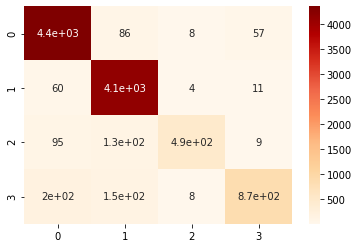

In [15]:
# 学習データ
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1])
print(train_cm)

# annot:Trueの場合セルに値を表示, cmap:Matplotlib のカラーマップまたは，オブジェクトを指定(詳細な色指定は以下参照)
# https://matplotlib.org/examples/color/colormaps_reference.html
sns.heatmap(train_cm, annot=True, cmap='OrRd')
plt.show()

[[531  16   1  14]
 [ 21 501   3   3]
 [ 23  21  43   4]
 [ 43  27   2  81]]


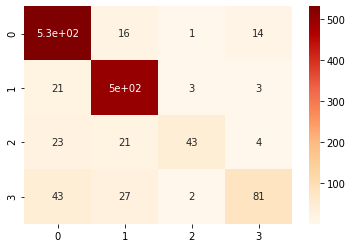

In [16]:
# 評価データ
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1])
print(test_cm)

sns.heatmap(test_cm, annot=True, cmap='OrRd')
plt.show()

## 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calc_scores(y_true, y_pred):
  col_list = ['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均']

  # 適合率（デフォルトでは1が陽性として算出）
  # average:Noneの場合，0, 1をそれぞれ陽性としたときの値がリストとして返る
  # average:'micro'の場合，陽性・陰性を入れ替えたそれぞれの状態でのTPやFP，FNの合計から適合率などを算出
  # average:'macro'の場合，陽性・陰性を入れ替えて算出した2つの値の算術平均
  # labels:軸の順番を指定
  precision = precision_score(test['CATEGORY'], test_pred[1], average=None, labels=col_list[:4])
  precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))

  # 再現率
  recall = recall_score(test['CATEGORY'], test_pred[1], average=None, labels=col_list[:4])
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
  f1 = f1_score(test['CATEGORY'], test_pred[1], average=None, labels=col_list[:4])
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1}, index=col_list)
  return scores

In [18]:
calc_scores(test['CATEGORY'], test_pred[1])

,適合率,再現率,F1スコア
b,0.859223,0.944840,0.900000
e,0.886726,0.948864,0.916743
t,0.794118,0.529412,0.635294
m,0.877551,0.472527,0.614286
マイクロ平均,0.866567,0.866567,0.866567
マクロ平均,0.854404,0.723911,0.766581


## 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [19]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,fed,ecb,bank,china,stocks,euro,oil,dollar,yellen,obamacare
重要度下位,and,ebola,video,her,google,aereo,apple,microsoft,star,drug




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,her,movie,film,star,jay,kim,she,jennifer
重要度下位,update,us,google,study,china,gm,says,facebook,data,billion




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,cancer,study,fda,drug,mers,cases,cdc,could,health
重要度下位,facebook,gm,google,deal,apple,bank,climate,ceo,sales,twitter




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,tesla,nasa,samsung,comcast,heartbleed
重要度下位,stocks,her,fed,percent,drug,cancer,ukraine,movie,american,his


## 58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [20]:
from tqdm import tqdm

result = []
# np.logspace(開始指数部, 終了指数部, リストの数, base=基数)
for C in tqdm(np.logspace(-3, 2, 10, base=10)):
  # モデルの学習
  lg = LogisticRegression(random_state=144, max_iter=144000, C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  train_pred = score_lg(lg, X_train)
  valid_pred = score_lg(lg, X_valid)
  test_pred = score_lg(lg, X_test)

  # 正解率の算出
  train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])
  test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])

  # 結果の格納
  result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [04:18<00:00, 25.81s/it]


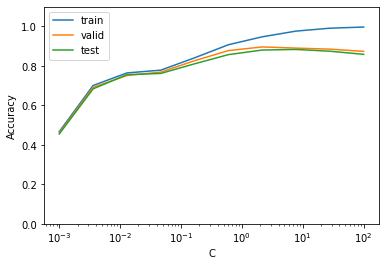

In [21]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

## 59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [22]:
!pip install optuna

In [24]:
import optuna

# 最適化対象を関数で指定
def objective_lg(trial):
  # チューニング対象パラメータのセット
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
  C = trial.suggest_loguniform('C', 1e-4, 1e4)

  # モデルの学習
  lg = LogisticRegression(random_state=144,
                          max_iter=14400,
                          penalty='elasticnet',
                          solver='saga',
                          l1_ratio=l1_ratio,
                          C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  valid_pred = score_lg(lg, X_valid)

  # 正解率の算出
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])

  return valid_accuracy

In [ ]:
# 最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective_lg, timeout=600) # timeout=秒数

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

In [27]:
# パラメータの設定
l1_ratio = trial.params['l1_ratio']
C = trial.params['C']

# モデルの学習
lg = LogisticRegression(random_state=144, 
                        max_iter=14400, 
                        penalty='elasticnet', 
                        solver='saga', 
                        l1_ratio=l1_ratio, 
                        C=C)
lg.fit(X_train, train['CATEGORY'])

# 予測値の取得
train_pred = score_lg(lg, X_train)
valid_pred = score_lg(lg, X_valid)
test_pred = score_lg(lg, X_test)

# 正解率の算出
train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1]) 
valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1]) 
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1]) 

print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（検証データ）：{valid_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.998
正解率（検証データ）：0.864
正解率（評価データ）：0.853
